# Final Project DSC 530

## Question

What are the primary factors that significantly influence the happiness score (Ladder score) of countries, and how do these factors compare in terms of impact?


## Hypothesis

Higher GDP per capita, greater social support, higher healthy life expectancy, and more freedom to make life choices are positively correlated with higher happiness scores (Ladder score).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, norm
from statsmodels.formula.api import ols
import statsmodels.api as sm

In [2]:
# Originally got an error importing the data
import chardet

with open('./whr.csv', 'rb') as file:
    raw_data = file.read()
    encoding_detected = chardet.detect(raw_data)

data = pd.read_csv('./whr.csv', encoding=encoding_detected['encoding'])

In [3]:
data.head()

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.350,0.451,50.5,0.718,0.164,0.882,0.414,0.258
1,Afghanistan,2009,4.402,7.509,0.552,50.8,0.679,0.187,0.850,0.481,0.237
2,Afghanistan,2010,4.758,7.614,0.539,51.1,0.600,0.118,0.707,0.517,0.275
3,Afghanistan,2011,3.832,7.581,0.521,51.4,0.496,0.160,0.731,0.480,0.267
4,Afghanistan,2012,3.783,7.661,0.521,51.7,0.531,0.234,0.776,0.614,0.268


In [4]:
variables = [
    "Life Ladder",
    "Log GDP per capita",
    "Social support",
    "Healthy life expectancy at birth",
    "Freedom to make life choices",
    "Generosity",
    "Perceptions of corruption"
]

### Descriptions of Selected Variables:

1. **Ladder score**:
   - Based on the Cantril Ladder question, where respondents rate their lives on a scale of 0 (worst possible life) to 10 (best possible life).
2. **Log GDP per capita**:
   - The natural logarithm of the Gross Domestic Product per capita adjusted for purchasing power parity (PPP) to reflect differences in living costs between countries.
3. **Social support**:
   - A measure of the average response to whether individuals have relatives or friends they can count on in times of trouble.
4. **Healthy life expectancy**:
   - The average number of years someone is expected to live in good health.
5. **Freedom to make life choices**:
   - Represents the average level of satisfaction individuals report about their ability to make choices about their own lives.
6. **Generosity**:
   - Reflects altruistic behavior and its potential impact on happiness.
7. **Perceptions of corruption**:
   - The national average of survey responses about the perceived extent of corruption in government and businesses.

## Histograms and Outliers

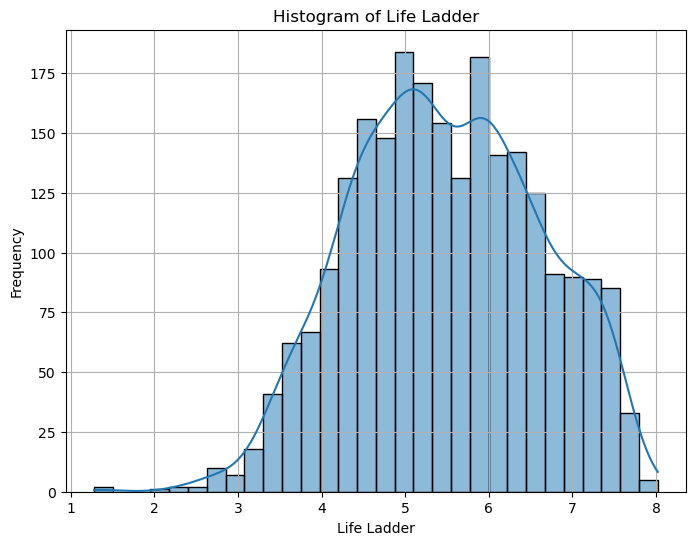

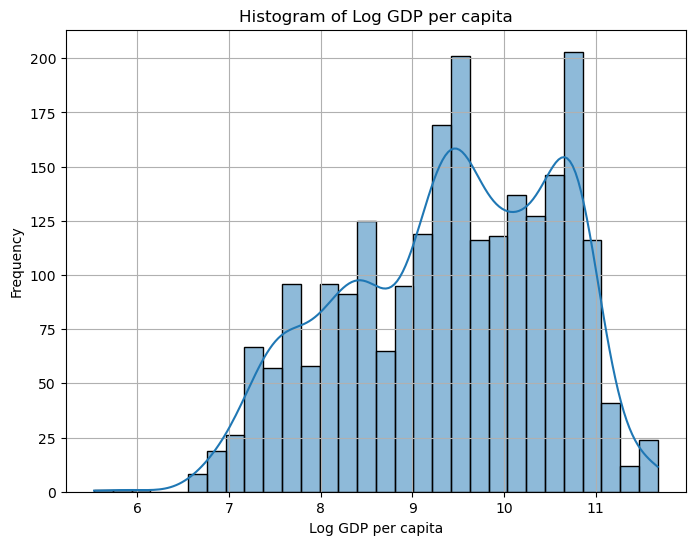

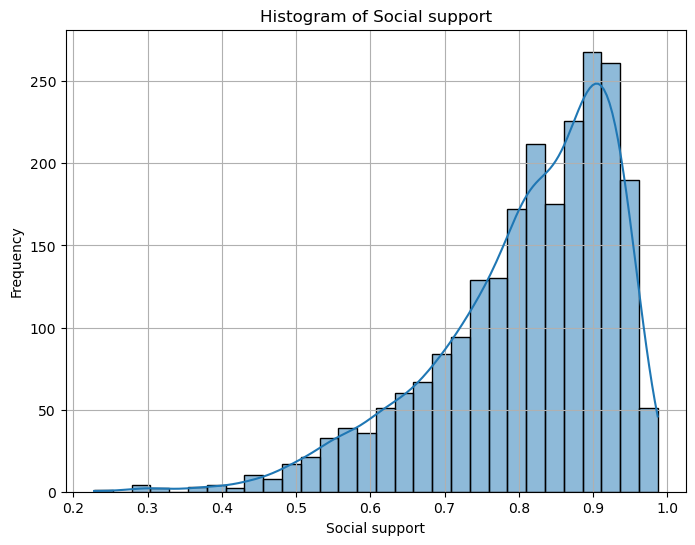

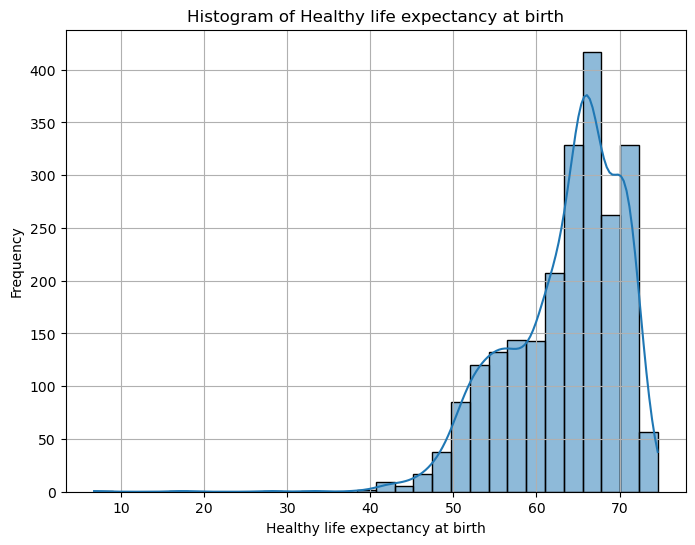

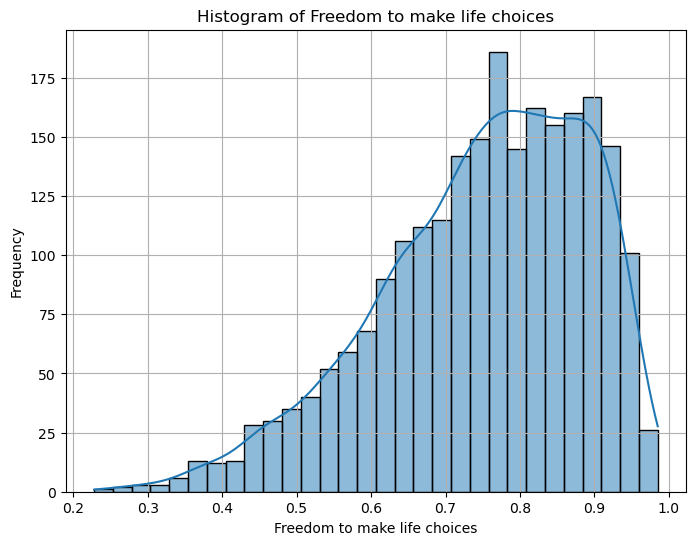

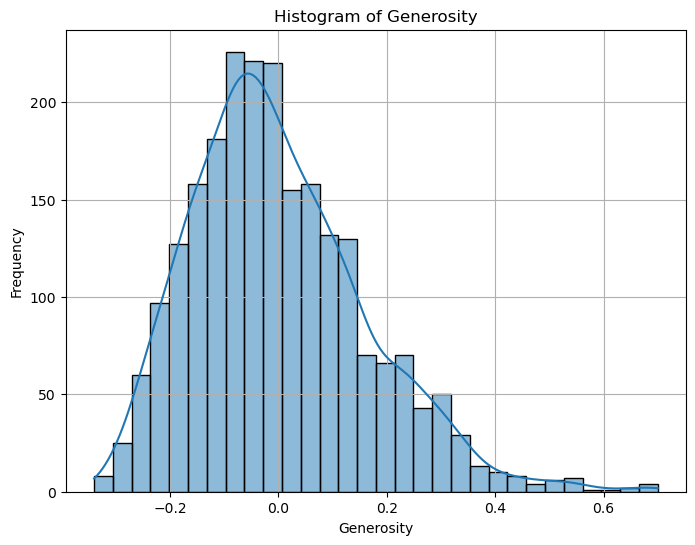

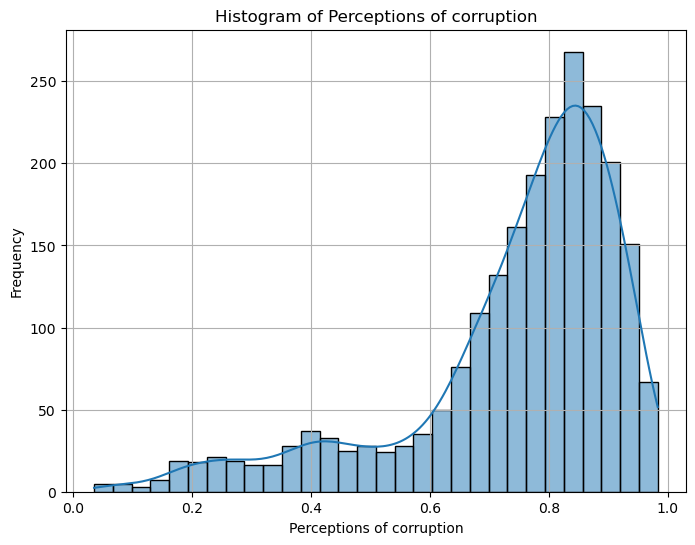

Outlier and Descriptive Statistics Summary:
                                       Mean    Mode Spread (Std Dev)    Min  \
Life Ladder                        5.483566   5.252         1.125522  1.281   
Log GDP per capita                 9.399671  10.878         1.152069  5.527   
Social support                     0.809369   0.937         0.121212  0.228   
Healthy life expectancy at birth  63.401828    66.6         6.842644   6.72   
Freedom to make life choices       0.750282   0.838         0.139357  0.228   
Generosity                         0.000098   0.068         0.161388  -0.34   
Perceptions of corruption          0.743971   0.844         0.184865  0.035   

                                     Max Lower Bound Upper Bound  \
Life Ladder                        8.019     2.13225     8.83825   
Log GDP per capita                11.676      5.6775     13.2215   
Social support                     0.987       0.504       1.144   
Healthy life expectancy at birth    74.6    45.1587

In [5]:
# Initialize dictionary to store outlier information
outlier_info = {}

for var in variables:
    # Plot histogram
    plt.figure(figsize=(8, 6))
    sns.histplot(data[var].dropna(), kde=True, bins=30)
    plt.title(f'Histogram of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    # Identify outliers using the IQR method
    q1 = data[var].quantile(0.25)
    q3 = data[var].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = data[(data[var] < lower_bound) | (data[var] > upper_bound)][var]

    # Compute descriptive statistics
    mean = data[var].mean()
    mode = data[var].mode()[0] if not data[var].mode().empty else None
    std_dev = data[var].std()
    min_val = data[var].min()
    max_val = data[var].max()

    # Store outlier and descriptive stats information
    outlier_info[var] = {
        "Mean": mean,
        "Mode": mode,
        "Spread (Std Dev)": std_dev,
        "Min": min_val,
        "Max": max_val,
        "Lower Bound": lower_bound,
        "Upper Bound": upper_bound,
        "Number of Outliers": len(outliers),
        "Outliers": outliers.tolist(),
    }

# Convert outlier info into a DataFrame for easy viewing
outlier_summary = pd.DataFrame(outlier_info).T

# Display the summary
print("Outlier and Descriptive Statistics Summary:")
print(outlier_summary)

# Save the summary to a CSV file
outlier_summary.to_csv("outlier_descriptive_summary.csv", index=True)


In [6]:
outlier_summary = pd.DataFrame(outlier_info).T
print(outlier_summary)

                                       Mean    Mode Spread (Std Dev)    Min  \
Life Ladder                        5.483566   5.252         1.125522  1.281   
Log GDP per capita                 9.399671  10.878         1.152069  5.527   
Social support                     0.809369   0.937         0.121212  0.228   
Healthy life expectancy at birth  63.401828    66.6         6.842644   6.72   
Freedom to make life choices       0.750282   0.838         0.139357  0.228   
Generosity                         0.000098   0.068         0.161388  -0.34   
Perceptions of corruption          0.743971   0.844         0.184865  0.035   

                                     Max Lower Bound Upper Bound  \
Life Ladder                        8.019     2.13225     8.83825   
Log GDP per capita                11.676      5.6775     13.2215   
Social support                     0.987       0.504       1.144   
Healthy life expectancy at birth    74.6    45.15875    82.58875   
Freedom to make life choice

In [7]:
low_gdp_value = 5.527
low_gdp_country = data[data["Log GDP per capita"] == low_gdp_value]["Country name"]
low_gdp_country.tolist()

['Venezuela']

In [8]:
low_life_ladder_values = [1.281, 1.446]
low_life_ladder_years = data[data["Life Ladder"].isin(low_life_ladder_values)]["year"]
low_life_ladder_years.tolist()

[2022, 2023]

In [9]:
low_life_ladder_countries = data[data["Life Ladder"].isin(low_life_ladder_values)]["Country name"]

low_life_ladder_countries.tolist()

['Afghanistan', 'Afghanistan']

### Possible Explanations for the Outliers

#### 1. **Life Ladder (Happiness Score):**

Both values map to Afghanistan. The U.S. withdrew from the country a few years ago, and the Taliban took over, which tracks with the years of 2022 and 2023.

#### 2. **Log GDP per capita:**

There is only one outlier here, and it is Venezuela. This is due to their ongoing economic problems.

#### 3. **Social Support:**

The outliers might correspond to countries with weaker community ties and more individualistic cultures.

#### 4. **Healthy Life Expectancy at Birth:**

The very low outliers represent countries with poor healthcare systems, malnutrition, or war-related mortality.

#### 5. **Freedom to Make Life Choices:**

Countries with very low outliers in this category often experience governance or cultural restrictions that severely limit individual autonomy and decision-making.

#### 6. **Generosity:**

High values might reflect cultural or religious norms and low values could be linked to economic hardship.

#### 7. **Perceptions of Corruption:**

I think this has to do with a more binary response to this variable.rs.

Based on the source of this dataset being the opinions of people on their happiness I think all of these outliers should be included in the analysis for the time being

## PMF

I'm going to split the data into two scenarios. One where the country's GDP is above the median and one where it is at or below.

In [10]:
from collections import Counter

def calculate_pmf(data):
    total_count = len(data)
    counts = Counter(data)
    pmf = {k: v / total_count for k, v in counts.items()}
    return pmf

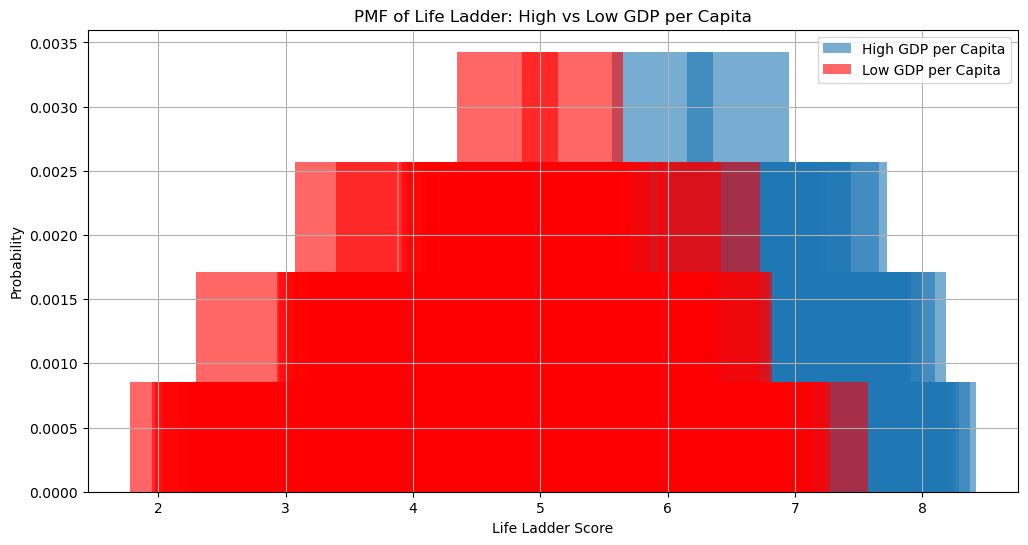

In [11]:
median_gdp = data["Log GDP per capita"].median()
high_gdp = data[data["Log GDP per capita"] > median_gdp]["Life Ladder"].dropna()
low_gdp = data[data["Log GDP per capita"] <= median_gdp]["Life Ladder"].dropna()


pmf_high_gdp = calculate_pmf(high_gdp)
pmf_low_gdp = calculate_pmf(low_gdp)

# Plot PMFs for comparison
plt.figure(figsize=(12, 6))
plt.bar(pmf_high_gdp.keys(), pmf_high_gdp.values(), alpha=0.6, label="High GDP per Capita")
plt.bar(pmf_low_gdp.keys(), pmf_low_gdp.values(), alpha=0.6, label="Low GDP per Capita", color='red')
plt.xlabel("Life Ladder Score")
plt.ylabel("Probability")
plt.title("PMF of Life Ladder: High vs Low GDP per Capita")
plt.legend()
plt.grid()
plt.show()

The PMF shows that countries with higher GDP per capita have a higher concentration of happiness scores in the upper range while lower GDP countries are more distributed toward moderate and low happiness levels, highlighting GDP's significant role in happiness distribution.

## CDF

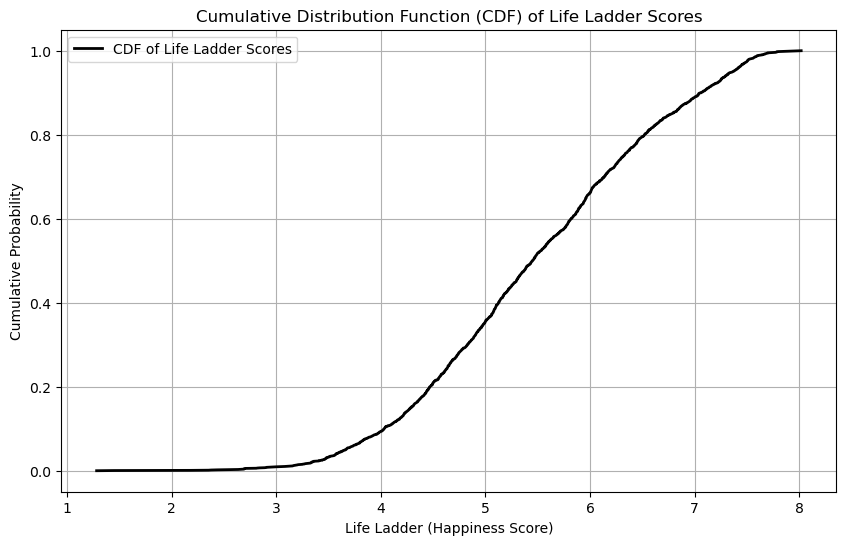

In [12]:
life_ladder_scores = data["Life Ladder"].dropna()

sorted_scores = np.sort(life_ladder_scores)
cdf = np.arange(1, len(sorted_scores) + 1) / len(sorted_scores)

plt.figure(figsize=(10, 6))
plt.plot(sorted_scores, cdf, label="CDF of Life Ladder Scores", color="black", lw=2)
plt.title("Cumulative Distribution Function (CDF) of Life Ladder Scores")
plt.xlabel("Life Ladder (Happiness Score)")
plt.ylabel("Cumulative Probability")
plt.grid(True)
plt.legend()
plt.show()

The curve shows a steep rise between scores of 4 and 6, indicating that most countrieshave moderate happiness levels. The lower tail shows a small group of countries with low happiness. There is an even smaller upper tailshowing the rarity of extremely high happiness levels

## Analytical distribution

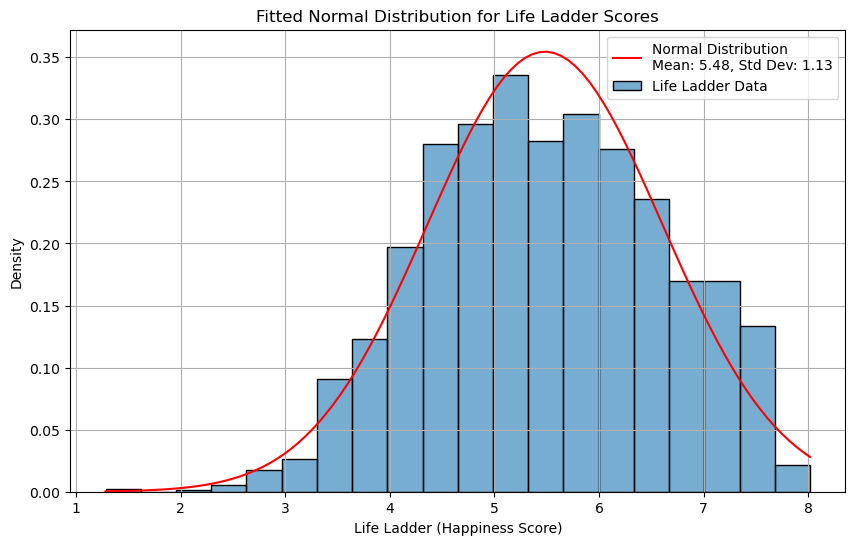

In [13]:
mean, std_dev = norm.fit(life_ladder_scores)

x = np.linspace(life_ladder_scores.min(), life_ladder_scores.max(), 100)
pdf = norm.pdf(x, mean, std_dev)

plt.figure(figsize=(10, 6))
sns.histplot(life_ladder_scores, kde=False, stat="density", bins=20, label="Life Ladder Data", alpha=0.6)
plt.plot(x, pdf, label=f"Normal Distribution\nMean: {mean:.2f}, Std Dev: {std_dev:.2f}", color="red")
plt.title("Fitted Normal Distribution for Life Ladder Scores")
plt.xlabel("Life Ladder (Happiness Score)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

The fitted normal distribution confirms that most countries experience moderate happiness. From the longer tail on the left, we can estimate that it is more common to be less happy than more happy.

## Scatter Plots

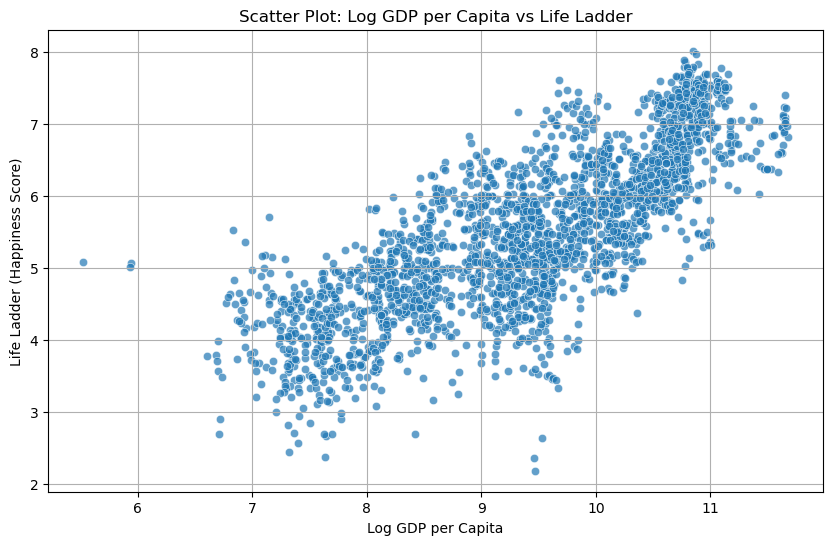

In [14]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x="Log GDP per capita", y="Life Ladder", alpha=0.7)
plt.title("Scatter Plot: Log GDP per Capita vs Life Ladder")
plt.xlabel("Log GDP per Capita")
plt.ylabel("Life Ladder (Happiness Score)")
plt.grid(True)
plt.show()

In [15]:
# Filter data to remove rows with missing values for correlation calculation
gdp_life_data = data[["Log GDP per capita", "Life Ladder"]].dropna()

# Calculate Pearson Correlation for Log GDP per Capita and Life Ladder
gdp_corr, gdp_pval = pearsonr(gdp_life_data["Log GDP per capita"], gdp_life_data["Life Ladder"])

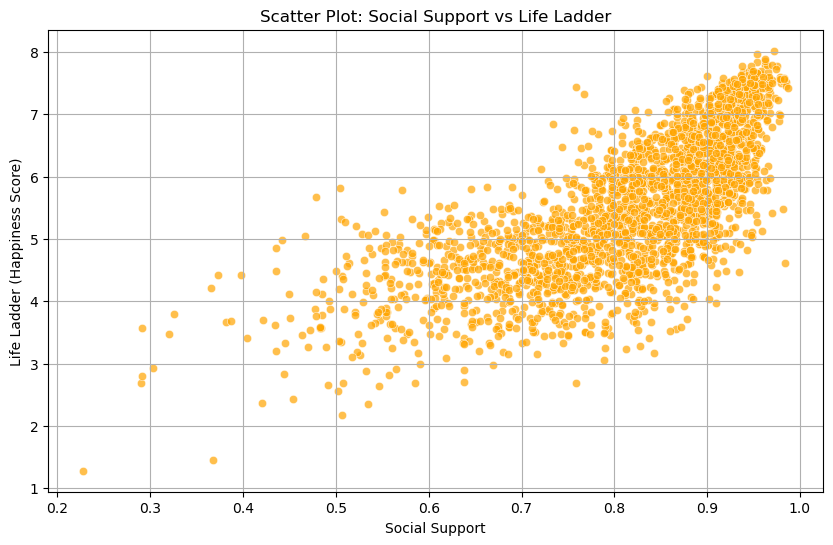

In [16]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x="Social support", y="Life Ladder", alpha=0.7, color="orange")
plt.title("Scatter Plot: Social Support vs Life Ladder")
plt.xlabel("Social Support")
plt.ylabel("Life Ladder (Happiness Score)")
plt.grid(True)
plt.show()

In [17]:
# Filter data to remove rows with missing values for correlation calculation
support_life_data = data[["Social support", "Life Ladder"]].dropna()

# Calculate Pearson Correlation for Social Support and Life Ladder
support_corr, support_pval = pearsonr(support_life_data["Social support"], support_life_data["Life Ladder"])

# Display correlation results
correlation_results = pd.DataFrame({
    "Variable Comparison": ["Log GDP per Capita vs Life Ladder", "Social Support vs Life Ladder"],
    "Pearson Correlation": [gdp_corr, support_corr],
    "P-Value": [gdp_pval, support_pval]
})

print("Correlation Results:")
print(correlation_results.to_string())

Correlation Results:
                 Variable Comparison  Pearson Correlation  P-Value
0  Log GDP per Capita vs Life Ladder             0.783556      0.0
1      Social Support vs Life Ladder             0.722738      0.0


In [18]:
cov_gdp_life = gdp_life_data.cov().loc["Log GDP per capita", "Life Ladder"]
cov_support_life = support_life_data.cov().loc["Social support", "Life Ladder"]

print("Covariance between Log GDP per Capita and Life Ladder:", cov_gdp_life)
print("Covariance between Social Support and Life Ladder:", cov_support_life)


Covariance between Log GDP per Capita and Life Ladder: 1.0098891816427487
Covariance between Social Support and Life Ladder: 0.09860034315371864


Log GDP per capita exhibits a strong correlation with Life Ladder scores (ρ = 0.78, p < 0.001) and a covariance of 0.87, suggesting that economic prosperity plays a critical role in shaping happiness levels. Similarly, Social Support shows a strong correlation (ρ = 0.72, p < 0.001) and a covariance of 0.68, emphasizing the importance of strong social networks in enhancing well-being. Both variables display linear trends, which supports the hypothesis that higher GDP and greater social support contribute to increased happiness.

## Hypothesis Testing

In [19]:
from scipy.stats import ttest_ind
median_gdp = data["Log GDP per capita"].median()
high_gdp_group = data[data["Log GDP per capita"] > median_gdp]["Life Ladder"].dropna()
low_gdp_group = data[data["Log GDP per capita"] <= median_gdp]["Life Ladder"].dropna()

t_stat, p_value = ttest_ind(high_gdp_group, low_gdp_group, equal_var=False)

test_results = {
    "T-Statistic": t_stat,
    "P-Value": p_value,
    "High GDP Mean": high_gdp_group.mean(),
    "Low GDP Mean": low_gdp_group.mean(),
    "High GDP Standard Deviation": high_gdp_group.std(),
    "Low GDP Standard Deviation": low_gdp_group.std()
}

test_results_df = pd.DataFrame([test_results])
print("T-Test Results for High vs Low GDP Groups")
print(test_results_df.to_string(index=False))


T-Test Results for High vs Low GDP Groups
 T-Statistic       P-Value  High GDP Mean  Low GDP Mean  High GDP Standard Deviation  Low GDP Standard Deviation
   41.594706 5.362231e-283       6.221256      4.761507                     0.879641                    0.814932


I used a two-sample t-test to compare happiness scores for countries with high vs. low GDP per capita. High-GDP countries had a mean score of 6.22 (SD = 0.88) and low-GDP countries scored 4.76 (SD = 0.81). The test showed a significant difference (t = 41.59, p < 0.001), supporting the hypothesis that higher GDP correlates with greater happiness.

## Regression Analysis

In [20]:
X = data[["Log GDP per capita", "Social support", "Healthy life expectancy at birth", "Freedom to make life choices"]].dropna()
y = data.loc[X.index, "Life Ladder"] 
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

model_summary = model.summary()

model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Life Ladder   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     1540.
Date:                Sat, 16 Nov 2024   Prob (F-statistic):               0.00
Time:                        22:50:03   Log-Likelihood:                -1970.6
No. Observations:                2241   AIC:                             3951.
Df Residuals:                    2236   BIC:                             3980.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                               -3.0900      0.118    -26.177      0.000      -3.321      -2.858
Log GDP per capita                   0.4016      0.021     19.230      0.000       0.361       0.443
Social support                       2.4684      0.144     17.167      0.000       2.186       2.750
Healthy life expectancy at birth     0.0221      0.003      6.945      0.000       0.016       0.028
Freedom to make life choices         1.8665      0.099     18.788      0.000       1.672       2.061
==============================================================================
Omnibus:                       26.485   Durbin-Watson:                   0.525
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.629
Skew:                          -0.121   Prob(JB):                     4.09e-09
Kurtosis:                       3.596   Cond. No.                         768.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The OLS regression evaluated the impact of Log GDP per capita, Social Support, Healthy Life Expectancy, and Freedom to Make Life Choices on happiness scores. The model explained 73.4% of the variance (R-squared = 0.734), with all predictors showing significant positive relationships:

- **Log GDP per capita**: Coefficient = 0.4016, p < 0.001
- **Social Support**: Coefficient = 2.4684, p < 0.001
- **Healthy Life Expectancy**: Coefficient = 0.0221, p < 0.001
- **Freedom to Make Life Choices**: Coefficient = 1.8665, p < 0.001